# A simple linear gan on Mnist dataset

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms 
import config as con
from torch.utils.data import DataLoader, random_split

# Dataset

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

In [27]:
dataset = ds.MNIST(con.path, True, transform=transform)#, download=True) unhash if not already downloaded
trainset, valset =  random_split(dataset, [int(len(dataset)*.9), len(dataset)-int(len(dataset)*.9)])
testset = ds.MNIST(con.path, False, transform=transform)#, download=True)

## visualizing

In [28]:
print(testset[0][1])
testset[0][0]

7


tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [29]:
total = len(trainset)
train = DataLoader(trainset, batch_size=con.batch_size, shuffle=True)
val = DataLoader(valset, batch_size=con.batch_size, shuffle=True)
test = DataLoader(testset, batch_size=con.batch_size, shuffle=True)

# Generator:

it learns to generate images that can defy discriminator(comming in later part)

In [57]:
class Block(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, device=con.DEVICE)
        self.batchnorm = nn.BatchNorm1d(out_features, device=con.DEVICE)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [62]:
class G(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.block1= Block(latent_dim, 256)
        self.block2 = Block(256, 512)
        self.block3 = Block(512, 784)
        self.tanh = nn.Tanh()

    def forward(self):
        if self.training:
            x = torch.randn((con.batch_size, self.latent_dim), device=self.block1.linear.weight.device)# Bxlatent
        else:
            x = torch.randn((1, self.latent_dim), device=self.block1.linear.weight.device) # 1xlatent
        x = self.block1(x) # Bx256
        x = self.block2(x) # Bx512
        x = self.block3(x) # Bx784
        x = self.tanh(x)   # Bx784
        if self.training:
            x = x.reshape(-1, 1, 28, 28) # Bx1x28x28
        else:
            x = x.reshape(1, 28, 28)
        return x


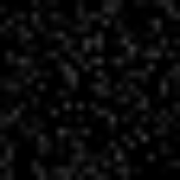

In [63]:
gen= G(100)
gen.eval()
im = to_pil_image(gen()) 
resize(im, (180, 180))

# Discriminator

classify image from generator as fake and from real data as real

In [64]:
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = Block(784, 512)
        self.block2 = Block(512, 256)
        self.block3 = Block(256, 1)


    def forward(self, x):
        x = x.view(-1, 784)# Bx784
        x = self.block1(x) # Bx512
        x = self.block2(x) # Bx256
        x = self.block3(x) # Bx1
        x = F.sigmoid(x)   # Bx1
        return x

In [65]:
gen.train()
dis = D()
dis(gen())[0:10,0]

tensor([0.5000, 0.5343, 0.5000, 0.6776, 0.5000, 0.5000, 0.5000, 0.6677, 0.5307,
        0.9587], device='cuda:0', grad_fn=<SelectBackward0>)

# training

In [66]:
# initialize models and optimizers
gen = G(10)
dis = D()
optimD = con.optimD(dis.parameters(), lr=con.lrD)
optimG = con.optimG(gen.parameters(), lr=con.lrG)

In [95]:
gen.train().to(con.DEVICE)
dis.train().to(con.DEVICE)
for epoch in range(con.epochs):
    for x, _ in train:
        x = x.to(con.DEVICE)
        fake = gen()
        real = x

        # Train Discriminator
        real_output = dis(real)
        fake_output = dis(fake)
        real_loss = F.binary_cross_entropy(real_output, torch.ones_like(real_output))
        fake_loss = F.binary_cross_entropy(fake_output, torch.zeros_like(fake_output))

        dis_loss = (real_loss + fake_loss)/2
        optimD.zero_grad()
        dis_loss.backward(retain_graph=True)
        optimD.step()

        # Train Generator
        gen_loss = F.binary_cross_entropy(fake_output, torch.ones_like(fake_output))
        optimG.zero_grad()
        gen_loss.backward()
        optimG.step()

    print(f"Epoch: {epoch} | Gen Loss: {gen_loss} | Dis Loss: {dis_loss}")


Epoch: 0 | Gen Loss: 0.6931471824645996 | Dis Loss: 0.5339926481246948
Epoch: 1 | Gen Loss: 0.6931471824645996 | Dis Loss: 0.5271292924880981
Epoch: 2 | Gen Loss: 0.691986083984375 | Dis Loss: 0.5300191044807434
Epoch: 3 | Gen Loss: 0.6931471824645996 | Dis Loss: 0.5243233442306519
Epoch: 4 | Gen Loss: 0.6836996078491211 | Dis Loss: 0.5315500497817993
Epoch: 5 | Gen Loss: 0.5806592702865601 | Dis Loss: 0.5944778919219971
Epoch: 6 | Gen Loss: 0.6803913116455078 | Dis Loss: 0.5414323806762695
Epoch: 7 | Gen Loss: 0.6241878271102905 | Dis Loss: 0.573613166809082
Epoch: 8 | Gen Loss: 0.6012418866157532 | Dis Loss: 0.5883415341377258
Epoch: 9 | Gen Loss: 0.6931471824645996 | Dis Loss: 0.5508902072906494
Epoch: 10 | Gen Loss: 0.6837158203125 | Dis Loss: 0.5410799980163574


KeyboardInterrupt: 

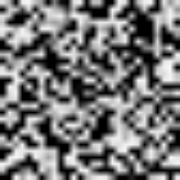

In [150]:
im = to_pil_image(gen()[0])
resize(im, (180, 180))